In [1]:
# import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import keras
from keras.layers import Dense,Input, InputLayer, Flatten
from keras.models import Sequential, Model, load_model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix,f1_score


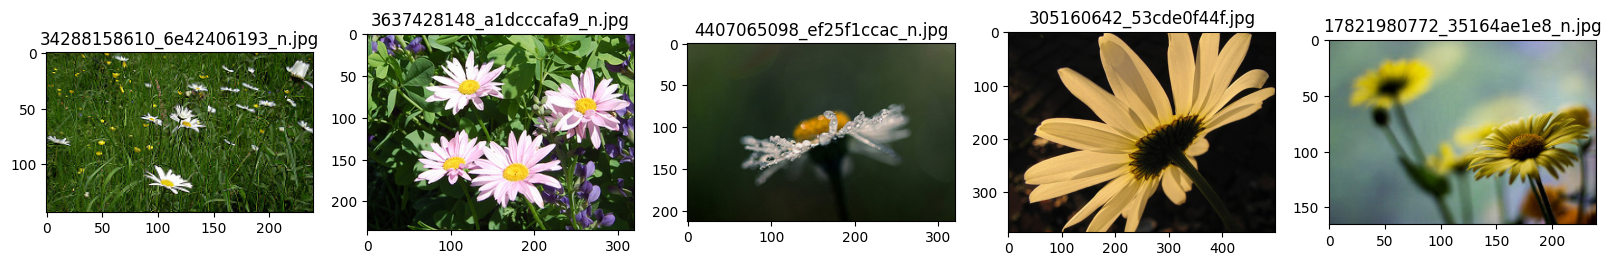

In [ ]:
#View some samples of the dataset
import random
plt.figure(figsize=(20,20))
folder=r'/kaggle/input/flowers-recognition/flowers/daisy'
for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path= os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)


In [3]:
!unzip flowers.zip


Archive:  flowers.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of flowers.zip or
        flowers.zip.zip, and cannot find flowers.zip.ZIP, period.


In [ ]:
def load_and_preprocess_data(data_dir, image_size):
    images = []
    labels = []

    # Iterate through each folder (each class of flowers)
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)

        # Iterate through each image in the class folder
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            # Read image and resize
            image = cv2.imread(image_path) #reads in BGR format
            #To read an image in grayscale
            #image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, image_size)

            # Normalize pixel values to [0, 1]
            image = image.astype('float32') / 255.0

            # Append to the lists
            images.append(image)
            labels.append(class_name)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels



In [ ]:
dataset_dir = "/kaggle/input/flowers-recognition/flowers"

In [ ]:
image_size = (128, 128)

images, labels = load_and_preprocess_data(dataset_dir, image_size)

In [ ]:
images

array([[[[0.1764706 , 0.17254902, 0.15294118],
         [0.18039216, 0.18039216, 0.16078432],
         [0.1882353 , 0.19215687, 0.16862746],
         ...,
         [0.20392157, 0.13333334, 0.08627451],
         [0.20392157, 0.13333334, 0.08627451],
         [0.20392157, 0.13333334, 0.08627451]],

        [[0.1764706 , 0.1764706 , 0.15686275],
         [0.18431373, 0.18039216, 0.16470589],
         [0.1882353 , 0.19215687, 0.17254902],
         ...,
         [0.2       , 0.13333334, 0.08627451],
         [0.20392157, 0.13333334, 0.08627451],
         [0.20392157, 0.13725491, 0.09019608]],

        [[0.18039216, 0.1764706 , 0.16078432],
         [0.18431373, 0.1882353 , 0.16862746],
         [0.19215687, 0.19607843, 0.17254902],
         ...,
         [0.2       , 0.13725491, 0.08627451],
         [0.2       , 0.13725491, 0.08627451],
         [0.20784314, 0.14117648, 0.09411765]],

        ...,

        [[0.10588235, 0.19607843, 0.32156864],
         [0.10196079, 0.19215687, 0.3137255 ]

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Convert class labels to one-hot encoded vectors
label_encoder = LabelEncoder()
encoded_class_names = label_encoder.fit_transform(labels)

In [ ]:
encoded_class_names

array([1, 1, 1, ..., 2, 2, 2])

In [ ]:
labels

array(['dandelion', 'dandelion', 'dandelion', ..., 'rose', 'rose', 'rose'],
      dtype='<U9')

In [ ]:
from sklearn.model_selection import train_test_split


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_class_names, test_size=0.33, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check the shapes of the datasets
print("Train images shape:", X_train.shape)
print("Train labels shape:", X_test.shape)
print("Validation images shape:", y_train.shape)
print("Validation labels shape:", y_test.shape)


Train images shape: (2892, 128, 128, 3)
Train labels shape: (1425, 128, 128, 3)
Validation images shape: (2892,)
Validation labels shape: (1425,)


In [ ]:
y_train

array([1, 1, 4, ..., 4, 2, 1])

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(5, activation='softmax')
])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,517 (1.74 MB)

 Trainable params: 456,005 (1.74 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Compile the model
initial_lr = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50


2024-05-01 19:00:23.223649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-05-01 19:00:23.223730: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-05-01 19:00:23.223740: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-05-01 19:00:23.223751: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-05-01 19:00:23.223769: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-05-01 19:00:23.223790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-05-01 19:00:23.223880: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-05-01 19:00:23.223895: E exte

 5/73 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2465 - loss: 1.6160

I0000 00:00:1714590030.125020     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3560 - loss: 1.4287

2024-05-01 19:00:34.260228: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 4.02921, expected 3.30225
2024-05-01 19:00:34.260283: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16385: 5.90096, expected 5.17401
2024-05-01 19:00:34.260303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16387: 4.91115, expected 4.1842
2024-05-01 19:00:34.260312: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16388: 4.45818, expected 3.73122
2024-05-01 19:00:34.260320: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16389: 4.77732, expected 4.05036
2024-05-01 19:00:34.260327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16390: 4.28491, expected 3.55796
2024-05-01 19:00:34.260334: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16391: 3.78731, expected 3.06035
2024-05-01 19:00:34.260342: 

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3571 - loss: 1.4265

2024-05-01 19:00:39.919303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.34921, expected 2.46525
2024-05-01 19:00:39.919362: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.92983, expected 5.04587
2024-05-01 19:00:39.919371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.86817, expected 4.98421
2024-05-01 19:00:39.919379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.9159, expected 4.03194
2024-05-01 19:00:39.919387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.84035, expected 3.95638
2024-05-01 19:00:39.919404: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.60006, expected 3.7161
2024-05-01 19:00:39.919412: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.34646, expected 3.4625
2024-05-01 19:00:39.919419: E external/local_xla/xla/servi

73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.3576 - loss: 1.4254 - val_accuracy: 0.3368 - val_loss: 1.4187
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4485 - loss: 1.2661 - val_accuracy: 0.4508 - val_loss: 1.2920
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4652 - loss: 1.2154 - val_accuracy: 0.3558 - val_loss: 1.5219
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5010 - loss: 1.1586 - val_accuracy: 0.4059 - val_loss: 1.5680
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5597 - loss: 1.0742 - val_accuracy: 0.4421 - val_loss: 1.3301
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5710 - loss: 1.0612 - val_accuracy: 0.5026 - val_loss: 1.1859
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6126 - loss: 1.0194 - val_accuracy: 0.4594 - val_loss: 1.2871
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6256 - loss: 0.9677 - val_accuracy: 0.5026 - val_loss: 

In [ ]:
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
#predicted_class_names = label_encoder.inverse_transform(predicted_labels)

f1 = f1_score(y_test, predicted_labels, average='macro')
report = classification_report(y_test, predicted_labels)

print("F1 Score:", f1)
print("Classification Report:")
print(report)

36/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2024-05-01 19:02:30.304956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 4.17829, expected 3.61709
2024-05-01 19:02:30.305010: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16391: 3.8394, expected 3.2782
2024-05-01 19:02:30.305026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16392: 4.02634, expected 3.46514
2024-05-01 19:02:30.305044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16393: 3.87915, expected 3.31795
2024-05-01 19:02:30.305055: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16416: 4.5964, expected 4.0352
2024-05-01 19:02:30.305067: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16463: 4.5263, expected 3.9651
2024-05-01 19:02:30.305078: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16464: 3.85564, expected 3.29444
2024-05-01 19:02:30.305088: E ext

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
F1 Score: 0.7704130154229445
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.86      0.76       268
           1       0.87      0.80      0.83       361
           2       0.69      0.68      0.69       253
           3       0.81      0.83      0.82       239
           4       0.81      0.70      0.75       304

    accuracy                           0.77      1425
   macro avg       0.77      0.77      0.77      1425
weighted avg       0.78      0.77      0.77      1425

